<a href="https://colab.research.google.com/github/Salsabilaurelia1408/tugasakhirsalsa/blob/main/WOPR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


            Date    WOPR  WWPR   WGPR  GOR   WBHP
Time                                             
5     2015-07-06  1314.0   0.0  0.240  183  323.0
6     2015-07-07  1321.0   0.0  0.260  197  335.0
7     2015-07-08  1309.0   0.0  0.247  189  343.0
8     2015-07-09  1299.0   0.0  0.233  179  348.0
9     2015-07-10  1287.0   0.0  0.240  186  349.0
...          ...     ...   ...    ...  ...    ...
686   2017-05-17   501.2  13.1  0.315  628  239.0
687   2017-05-18   501.3  12.4  0.313  624  240.0
688   2017-05-19   500.2  12.5  0.314  628  239.0
689   2017-05-20   503.1  11.5  0.311  618  241.0
690   2017-05-21   503.1  11.5  0.311  618  241.0

[629 rows x 6 columns]


<Axes: xlabel='Time'>

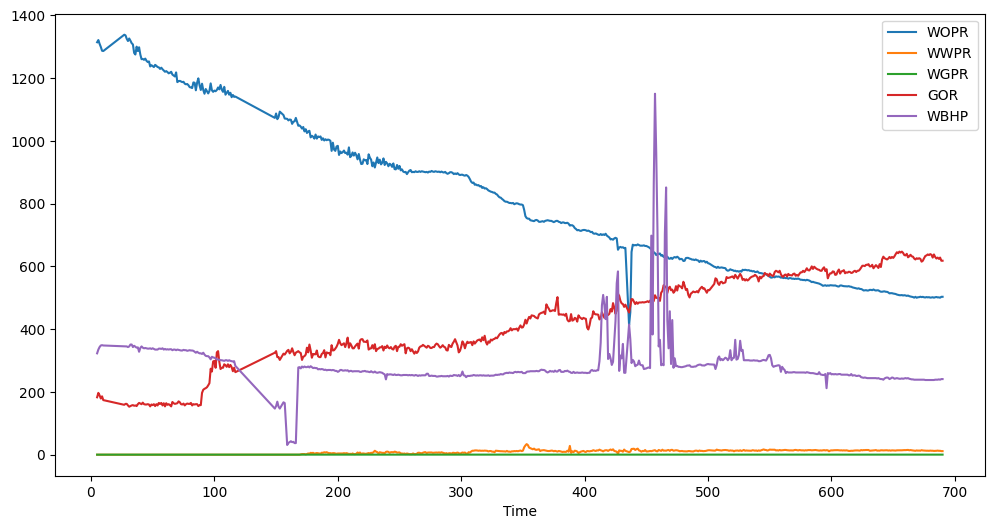

In [69]:
# Load data
url ='https://raw.githubusercontent.com/Salsabilaurelia1408/tugasakhirsalsa/main/WOPR2_DateFormatRevised.csv'

df = pd.read_csv(url, index_col='Time', parse_dates=True)
'''
df.set_index('Date', inplace=True)
df.index.freq ='MS'
'''

print(df)

df.plot(figsize=(12,6))


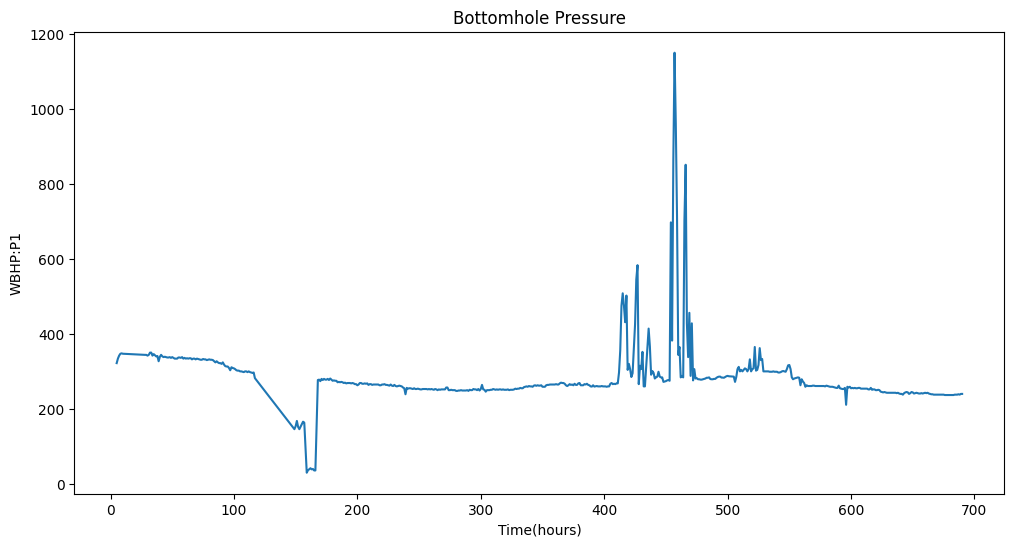

In [70]:
df['WBHP'].plot(x='Time', y='WBHP', figsize=(12, 6))
plt.title('Bottomhole Pressure')
plt.xlabel('Time(hours)')
plt.ylabel('WBHP:P1')
plt.show()


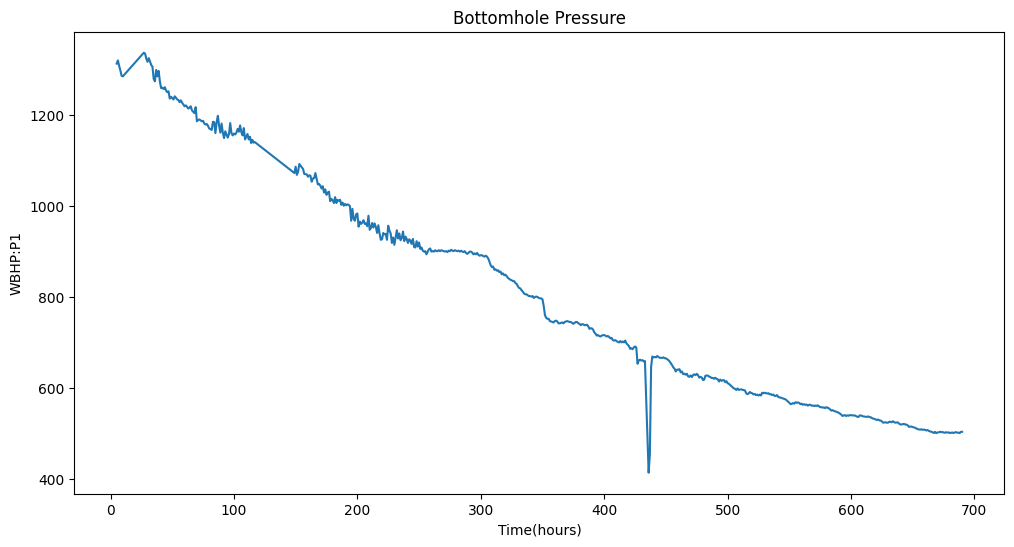

In [71]:
df['WOPR'].plot(x='Time', y='WOPR', figsize=(12, 6))
plt.title('Bottomhole Pressure')
plt.xlabel('Time(hours)')
plt.ylabel('WBHP:P1')
plt.show()

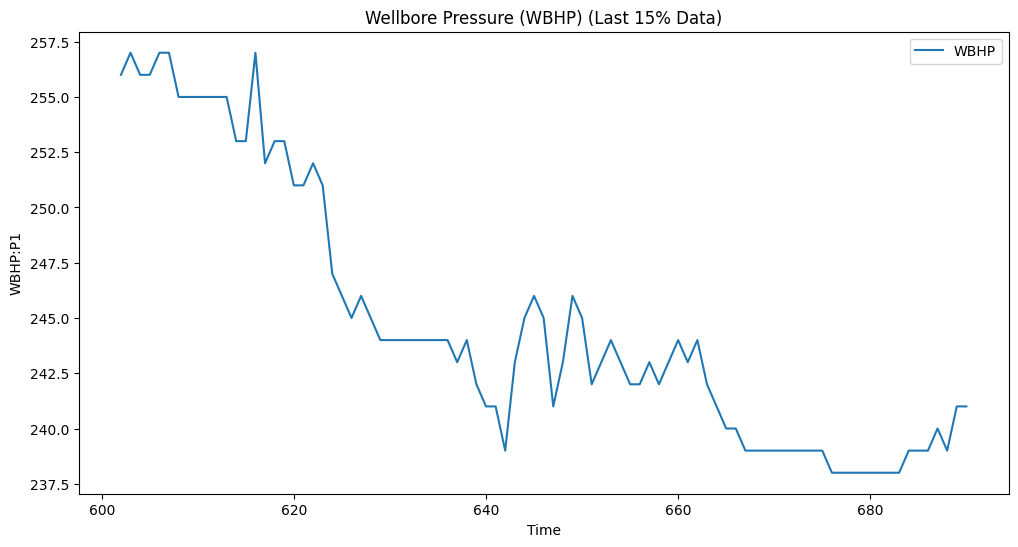

In [72]:
df = pd.read_csv(url, index_col='Time', parse_dates=True)
start_index = int(len(df) * 0.86)
end_index = len(df)
subset_df = df.iloc[start_index:end_index][['WBHP']]
subset_df.plot(figsize=(12, 6))
plt.title('Wellbore Pressure (WBHP) (Last 15% Data)')
plt.xlabel('Time')
plt.ylabel('WBHP:P1')
plt.show()


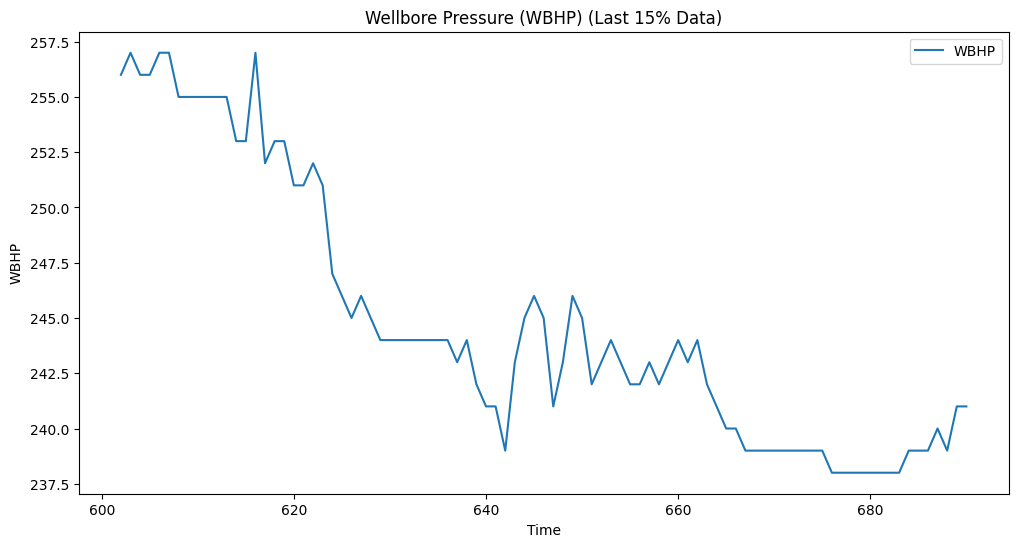

In [73]:
df = pd.read_csv(url, index_col='Time', parse_dates=True)
start_index = int(len(df) * 0.86)
end_index = len(df)
subset_df = df.iloc[start_index:end_index][['WBHP']]
subset_df.plot(figsize=(12, 6))
plt.title('Wellbore Pressure (WBHP) (Last 15% Data)')
plt.xlabel('Time')
plt.ylabel('WBHP')
plt.show()

In [74]:
def load_data(filename):
    """
    This function reads csv file from the given url and extracts time-series data of oil & water rate,
    pressure, and water cut.
    :param filename: the url of csv file (stored in GitHub)
    :return: t: vector of time; qo: matrix of oil rate in all wells; qo: matrix of water rate in all wells;
            and p: matrix of bottom hole pressure in all wells
    """
    df = pd.read_csv(filename)

    t = df.loc[:, ['Time']] # Time in simulation: DAY
    t *= 24 # Converting time from DAY to HOUR
    qo = df.loc[:, ['WOPR']]
    qw = df.loc[:, ['WWPR']]
    p = df.loc[:, ['WBHP']]
    qg = df.loc[:, ['WGPR']]
    return t, qo, qw, qg, p

In [75]:
t, qo, qw, wc, p = load_data('https://raw.githubusercontent.com/Salsabilaurelia1408/tugasakhirsalsa/main/WOPR2_DateFormatRevised.csv')

In [76]:
# Define input and output variables
X = df[['WBHP','WWPR', 'WGPR', 'GOR']]
Y = df['WOPR']



In [77]:
def plot_loss(history, title):
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss', linewidth=3)
    plt.plot(history.history['val_loss'], label='Dev Loss', linewidth=3)
    plt.legend()
    plt.grid()
    plt.xlabel("No of Epochs", fontsize=15)
    plt.ylabel("Loss", fontsize=15)
    plt.title('Loss - ' + title, fontsize=15)
    plt.xlim(0, len(history.history['loss']))
    plt.ylim(0, max(history.history['val_loss']))
    plt.show()

def plot_pred_rate(t, q_actual, q_pred, dev_fraction, test_fraction, well):
    """This function plots actual and predicted bottom hole pressure"""
    # Plotting pwf v time
    plt.figure()
    plt.plot(t, q_actual, 'k-', lw=3)
    plt.title('Actual oil rate')

    # Training
    train_end = int((1 - dev_fraction - test_fraction) * q_pred.shape[0])
    plt.plot(t[0:train_end], q_pred[0:train_end],
                 'r-', mec ='red', lw=3)
    plt.title('Training Set')

    # Dev
    dev_end = int((1 - test_fraction) * q_pred.shape[0])
    plt.plot(t[train_end:dev_end], q_pred[train_end:dev_end],
                 'y-', mec ='orange', lw=3)
    plt.title('Dev Set')

    # Test
    plt.plot(t[dev_end:], q_pred[dev_end:],
                 'g-', mec ='green', lw =3)    
    plt.title('Test Set')


    plt.xlabel("Time (hours)", fontsize=14)
    plt.ylabel("Flow Rate Oil (STB/d)", fontsize=14)
    plt.title("Flow Rate Oil " +str(well), y=1, fontsize=13)
    plt.legend(loc="best", prop=dict(size=14))
    plt.xlim(0, max(t))
    plt.ylim(480, max(max(q_actual), max(q_pred)) + 10)
    plt.grid(True)

# Reshape data to fit the input shape of the models
def reshape_data(X,Y, look_back=1):
    dataX = []
    dataY = []
    '''
    for i in range(look_back, len(Data)):
        X.append(data[i-look_back:i, :])
        Y.append(data[i, 0])
    '''
    for i in range(len(X) - look_back):
        a = X[i:(i + look_back), :]
        b = Y[i + look_back, :]
        dataX.append(a)
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

In [78]:


test_fraction = 0.15
X_traindev_raw, X_test_raw, Y_traindev_raw, Y_test_raw = train_test_split(X, Y, test_size=test_fraction, shuffle=False)
dev_fraction = 0.15
X_train_raw, X_dev_raw, Y_train_raw, Y_dev_raw = train_test_split(X_traindev_raw, Y_traindev_raw, test_size=dev_fraction/(1-test_fraction), shuffle=False)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train_raw)
X_dev_scaled = scaler.fit_transform(X_dev_raw)
X_test_scaled = scaler.fit_transform(X_test_raw)

Y_train_scaled = scaler.fit_transform(np.array(Y_train_raw).reshape(-1,1))
Y_dev_scaled = scaler.fit_transform(np.array(Y_dev_raw).reshape(-1,1))
Y_test_scaled = scaler.fit_transform(np.array(Y_test_raw).reshape(-1,1))

X_train, Y_train = reshape_data(X_train_scaled, Y_train_scaled, look_back=10)
X_dev, Y_dev = reshape_data(X_dev_scaled, Y_dev_scaled, look_back=10)
X_test, Y_test = reshape_data(X_test_scaled, Y_test_scaled, look_back=10)


# Define LSTM model
model_LSTM = Sequential()
model_LSTM.add(LSTM(512, activation='relu', input_shape=(10, 4)))
model_LSTM.add(Dense(1, activation = 'linear'))
model_LSTM.add(Dropout(0.2))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_LSTM.compile(optimizer=optimizer, loss='mean_squared_error', metrics =['mae', 'accuracy'])

# Define GRU model
model_GRU = Sequential()
model_GRU.add(GRU(512, activation='relu', input_shape=(10, 4)))
model_GRU.add(Dense(1, activation = 'linear'))
model_GRU.add(Dropout(0.2))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_GRU.compile(optimizer=optimizer, loss='mean_squared_error', metrics =['mae', 'accuracy'])

# Define Vanilla RNN model
model_Vanilla = Sequential()
model_Vanilla.add(SimpleRNN(512, activation='relu', input_shape=(10, 4)))
model_Vanilla.add(Dense(1, activation = 'linear'))
model_Vanilla.add(Dropout(0.2))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_Vanilla.compile(optimizer=optimizer, loss='mean_squared_error', metrics =['mae', 'accuracy'])

# Train the models
history_LSTM = model_LSTM.fit(X_train, Y_train, epochs=50, batch_size=100, validation_data=(X_dev, Y_dev), verbose=1, shuffle = False)
history_GRU = model_GRU.fit(X_train, Y_train, epochs=50, batch_size =100, validation_data=(X_dev, Y_dev), verbose=1, shuffle = False)
history_Vanilla = model_Vanilla.fit(X_train, Y_train, epochs=50, batch_size=100, validation_data=(X_dev, Y_dev), verbose=1, shuffle = False)

'''
# Predict using the models
Y_pred_LSTM = model_LSTM.predict(X_test)
Y_pred_GRU = model_GRU.predict(X_test)
Y_pred_Vanilla = model_Vanilla.predict(X_test)

# Reshape predicted and actual values
Y_pred_LSTM = scaler.inverse_transform(Y_pred_LSTM.reshape(-1, 1))
Y_pred_GRU = scaler.inverse_transform(Y_pred_GRU.reshape(-1, 1))
Y_pred_Vanilla = scaler.inverse_transform(Y_pred_Vanilla.reshape(-1, 1))
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

'''

Epoch 1/50
5/5 [==============================] - 5s 310ms/step - loss: 0.2684 - mae: 0.4466 - accuracy: 0.0023 - val_loss: 0.0371 - val_mae: 0.1514 - val_accuracy: 0.0118
Epoch 2/50
5/5 [==============================] - 1s 279ms/step - loss: 0.1589 - mae: 0.3165 - accuracy: 0.0000e+00 - val_loss: 0.0292 - val_mae: 0.1356 - val_accuracy: 0.0118
Epoch 3/50
5/5 [==============================] - 1s 275ms/step - loss: 0.1333 - mae: 0.2803 - accuracy: 0.0023 - val_loss: 0.0261 - val_mae: 0.1353 - val_accuracy: 0.0118
Epoch 4/50
5/5 [==============================] - 1s 277ms/step - loss: 0.1115 - mae: 0.2468 - accuracy: 0.0023 - val_loss: 0.0177 - val_mae: 0.1090 - val_accuracy: 0.0118
Epoch 5/50
5/5 [==============================] - 2s 429ms/step - loss: 0.0816 - mae: 0.1827 - accuracy: 0.0023 - val_loss: 0.0204 - val_mae: 0.1196 - val_accuracy: 0.0118
Epoch 6/50
5/5 [==============================] - 2s 340ms/step - loss: 0.0794 - mae: 0.1812 - accuracy: 0.0023 - val_loss: 0.0260 - val

'\n# Predict using the models\nY_pred_LSTM = model_LSTM.predict(X_test)\nY_pred_GRU = model_GRU.predict(X_test)\nY_pred_Vanilla = model_Vanilla.predict(X_test)\n\n# Reshape predicted and actual values\nY_pred_LSTM = scaler.inverse_transform(Y_pred_LSTM.reshape(-1, 1))\nY_pred_GRU = scaler.inverse_transform(Y_pred_GRU.reshape(-1, 1))\nY_pred_Vanilla = scaler.inverse_transform(Y_pred_Vanilla.reshape(-1, 1))\nY_test = scaler.inverse_transform(Y_test.reshape(-1, 1))\n\n'

**LSTM**

In [79]:
# Predict using the model
Y_pred_train = model_LSTM.predict(X_train)
Y_pred_dev = model_LSTM.predict(X_dev)
Y_pred_test = model_LSTM.predict(X_test)


# Reshape predicted and actual values
Y_pred_train_LSTM = scaler.inverse_transform(Y_pred_train.reshape(-1, 1))
Y_pred_dev_LSTM = scaler.inverse_transform(Y_pred_dev.reshape(-1, 1))
Y_pred_test_LSTM = scaler.inverse_transform(Y_pred_test.reshape(-1, 1))


Y_train_act = scaler.inverse_transform(Y_train.reshape(-1,1))
Y_dev_act = scaler.inverse_transform(Y_dev.reshape(-1,1))
Y_test_act = scaler.inverse_transform(Y_test.reshape(-1,1))

y_act = np.concatenate([Y_train_act, Y_dev_act, Y_test_act])
y_pred = np.concatenate([Y_pred_train_LSTM, Y_pred_dev_LSTM, Y_pred_test_LSTM])

3/3 [==============================] - 0s 24ms/step


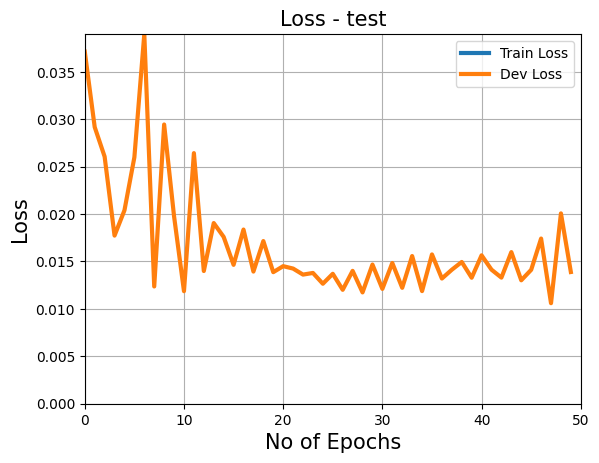

Training Set Score: 0.7391
Dev Set Score: 0.6478
Test Set Score: 0.8525
Training Set MSE: 18.9450
Dev Set MSE: 22.1093
Test Set MSE: 23.9435


In [80]:
plot_loss(history_LSTM, title='test')
train_mse, train_acc = mean_squared_error(Y_train_act, Y_pred_train_LSTM), r2_score(Y_train_act, Y_pred_train_LSTM)
dev_mse, dev_acc = mean_squared_error(Y_dev_act, Y_pred_dev_LSTM), r2_score(Y_dev_act, Y_pred_dev_LSTM)
test_mse, test_acc = mean_squared_error(Y_test_act, Y_pred_test_LSTM), r2_score(Y_test_act, Y_pred_test_LSTM)

print('Training Set Score: %1.4f' % train_acc)
print('Dev Set Score: %1.4f' % dev_acc)
print('Test Set Score: %1.4f' % test_acc)

print('Training Set MSE: %1.4f' % train_mse)
print('Dev Set MSE: %1.4f' % dev_mse)
print('Test Set MSE: %1.4f' % test_mse)

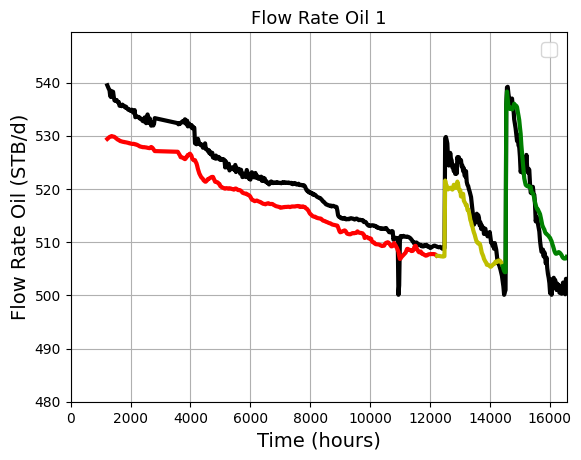

In [81]:
for i in range(y_act.shape[1]):
    plot_pred_rate(t[-len(y_act):].values,
                   y_act[:, i], y_pred[:, i], dev_fraction=dev_fraction, test_fraction=test_fraction, well=i+1)
    plt.savefig('traindev_LSTM_512_1024_lb25_well_' + str(i))

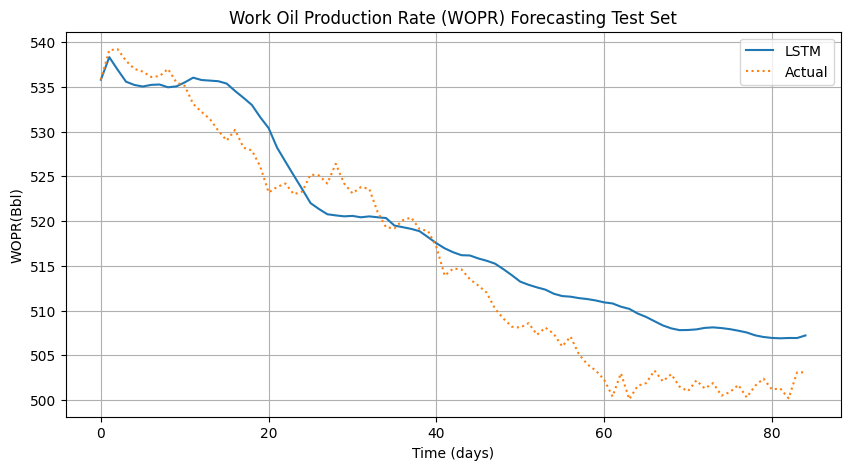

In [82]:
plt.figure(figsize=(10,5))
plt.plot(Y_pred_test_LSTM, label='LSTM')
plt.plot(Y_test_act, label='Actual', ls= "dotted")
plt.title('Work Oil Production Rate (WOPR) Forecasting Test Set')
plt.xlabel('Time (days)')
plt.ylabel('WOPR(Bbl)')
plt.grid(True)
plt.legend()
plt.show()

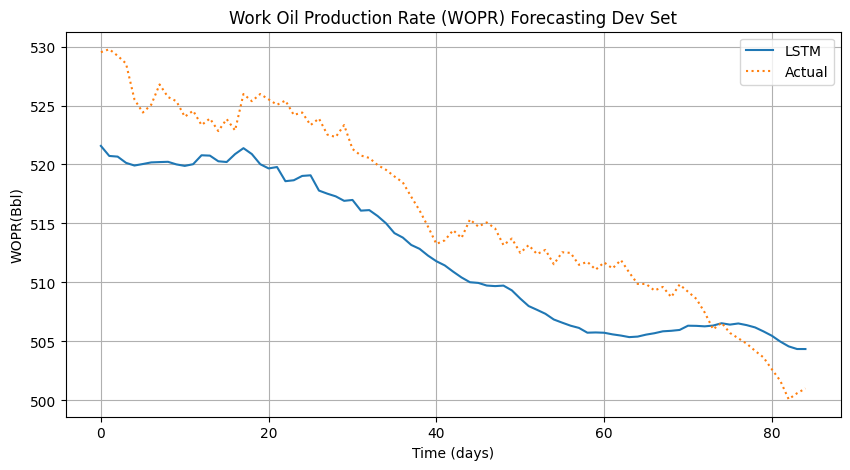

In [83]:
plt.figure(figsize=(10,5))
plt.plot(Y_pred_dev_LSTM, label='LSTM')
plt.plot(Y_dev_act, label='Actual', ls= "dotted")
plt.title('Work Oil Production Rate (WOPR) Forecasting Dev Set')
plt.xlabel('Time (days)')
plt.ylabel('WOPR(Bbl)')
plt.grid(True)
plt.legend()
plt.show()

**GRU**

In [84]:
# Predict using the model
Y_pred_train = model_GRU.predict(X_train)
Y_pred_dev = model_GRU.predict(X_dev)
Y_pred_test = model_GRU.predict(X_test)


# Reshape predicted and actual values
Y_pred_train_GRU = scaler.inverse_transform(Y_pred_train.reshape(-1, 1))
Y_pred_dev_GRU = scaler.inverse_transform(Y_pred_dev.reshape(-1, 1))
Y_pred_test_GRU = scaler.inverse_transform(Y_pred_test.reshape(-1, 1))


Y_train_act = scaler.inverse_transform(Y_train.reshape(-1,1))
Y_dev_act = scaler.inverse_transform(Y_dev.reshape(-1,1))
Y_test_act = scaler.inverse_transform(Y_test.reshape(-1,1))

y_act = np.concatenate([Y_train_act, Y_dev_act, Y_test_act])
y_pred = np.concatenate([Y_pred_train_GRU, Y_pred_dev_GRU, Y_pred_test_GRU])

3/3 [==============================] - 0s 18ms/step


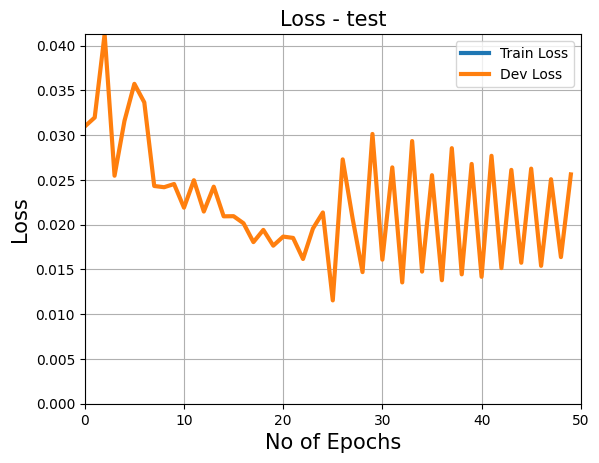

Training Set Score: 0.5852
Dev Set Score: 0.3503
Test Set Score: 0.7808
Training Set MSE: 30.1226
Dev Set MSE: 40.7808
Test Set MSE: 35.5793


In [85]:
plot_loss(history_GRU, title='test')
train_mse, train_acc = mean_squared_error(Y_train_act, Y_pred_train_GRU), r2_score(Y_train_act, Y_pred_train_GRU)
dev_mse, dev_acc = mean_squared_error(Y_dev_act, Y_pred_dev_GRU), r2_score(Y_dev_act, Y_pred_dev_GRU)
test_mse, test_acc = mean_squared_error(Y_test_act, Y_pred_test_GRU), r2_score(Y_test_act, Y_pred_test_GRU)

print('Training Set Score: %1.4f' % train_acc)
print('Dev Set Score: %1.4f' % dev_acc)
print('Test Set Score: %1.4f' % test_acc)

print('Training Set MSE: %1.4f' % train_mse)
print('Dev Set MSE: %1.4f' % dev_mse)
print('Test Set MSE: %1.4f' % test_mse)

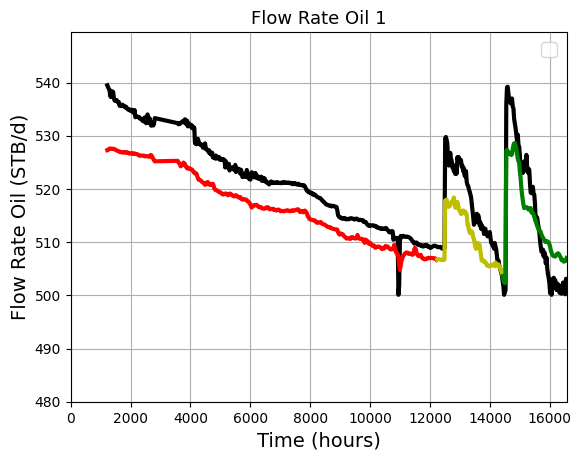

In [86]:
for i in range(y_act.shape[1]):
    plot_pred_rate(t[-len(y_act):].values,
                   y_act[:, i], y_pred[:, i], dev_fraction=dev_fraction, test_fraction=test_fraction, well=i+1)
    plt.savefig('traindev_LSTM_512_1024_lb25_well_' + str(i))

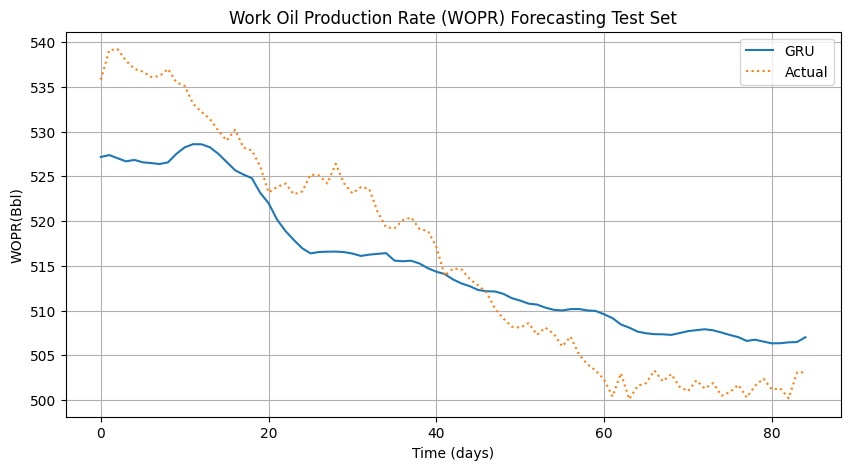

In [87]:
plt.figure(figsize=(10,5))
plt.plot(Y_pred_test_GRU, label='GRU')
plt.plot(Y_test_act, label='Actual', ls= "dotted")
plt.title('Work Oil Production Rate (WOPR) Forecasting Test Set')
plt.xlabel('Time (days)')
plt.ylabel('WOPR(Bbl)')
plt.grid(True)
plt.legend()
plt.show()

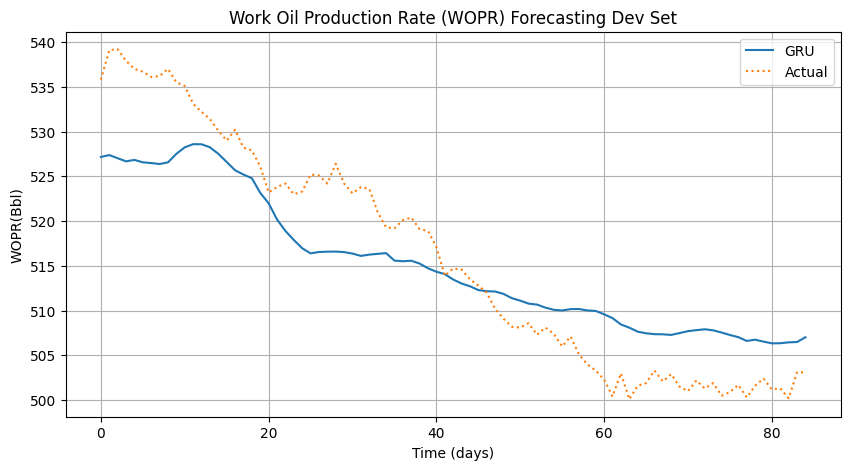

In [88]:
plt.figure(figsize=(10,5))
plt.plot(Y_pred_test_GRU, label='GRU')
plt.plot(Y_test_act, label='Actual', ls= "dotted")
plt.title('Work Oil Production Rate (WOPR) Forecasting Dev Set')
plt.xlabel('Time (days)')
plt.ylabel('WOPR(Bbl)')
plt.grid(True)
plt.legend()
plt.show()

**Vanilla RNN**

In [89]:
# Predict using the model
Y_pred_train = model_Vanilla.predict(X_train)
Y_pred_dev = model_Vanilla.predict(X_dev)
Y_pred_test = model_Vanilla.predict(X_test)


# Reshape predicted and actual values
Y_pred_train_RNN = scaler.inverse_transform(Y_pred_train.reshape(-1, 1))
Y_pred_dev_RNN = scaler.inverse_transform(Y_pred_dev.reshape(-1, 1))
Y_pred_test_RNN = scaler.inverse_transform(Y_pred_test.reshape(-1, 1))


Y_train_act = scaler.inverse_transform(Y_train.reshape(-1,1))
Y_dev_act = scaler.inverse_transform(Y_dev.reshape(-1,1))
Y_test_act = scaler.inverse_transform(Y_test.reshape(-1,1))

y_act = np.concatenate([Y_train_act, Y_dev_act, Y_test_act])
y_pred = np.concatenate([Y_pred_train_RNN, Y_pred_dev_RNN, Y_pred_test_RNN])

3/3 [==============================] - 0s 16ms/step


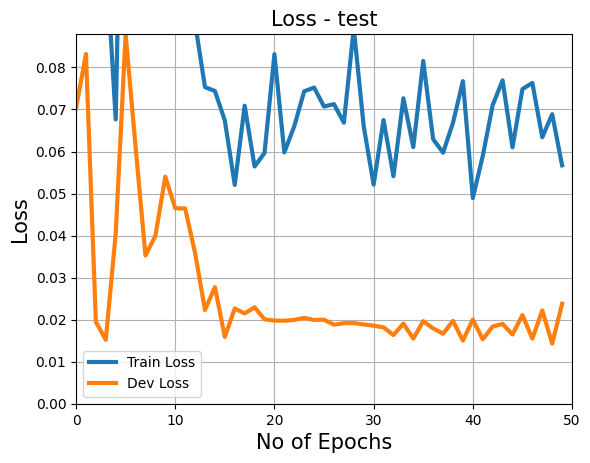

Training Set Score: 0.4852
Dev Set Score: 0.3968
Test Set Score: 0.8503
Training Set MSE: 37.3806
Dev Set MSE: 37.8650
Test Set MSE: 24.3025


In [91]:
plot_loss(history_Vanilla, title='test')
train_mse, train_acc = mean_squared_error(Y_train_act, Y_pred_train_RNN), r2_score(Y_train_act, Y_pred_train_RNN)
dev_mse, dev_acc = mean_squared_error(Y_dev_act, Y_pred_dev_RNN), r2_score(Y_dev_act, Y_pred_dev_RNN)
test_mse, test_acc = mean_squared_error(Y_test_act, Y_pred_test_RNN), r2_score(Y_test_act, Y_pred_test_RNN)

print('Training Set Score: %1.4f' % train_acc)
print('Dev Set Score: %1.4f' % dev_acc)
print('Test Set Score: %1.4f' % test_acc)

print('Training Set MSE: %1.4f' % train_mse)
print('Dev Set MSE: %1.4f' % dev_mse)
print('Test Set MSE: %1.4f' % test_mse)

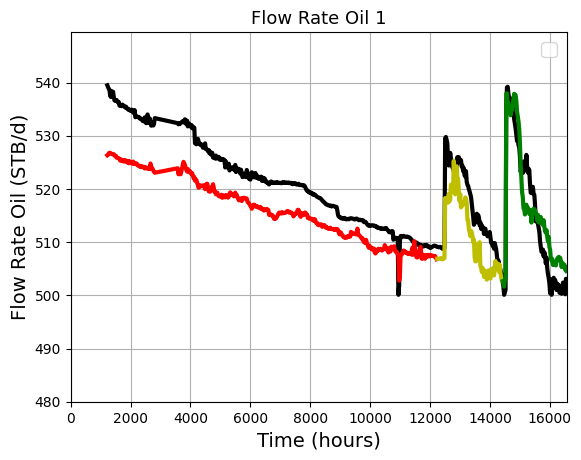

In [92]:
for i in range(y_act.shape[1]):
    plot_pred_rate(t[-len(y_act):].values,
                   y_act[:, i], y_pred[:, i], dev_fraction=dev_fraction, test_fraction=test_fraction, well=i+1)
    plt.savefig('traindev_LSTM_512_1024_lb25_well_' + str(i))

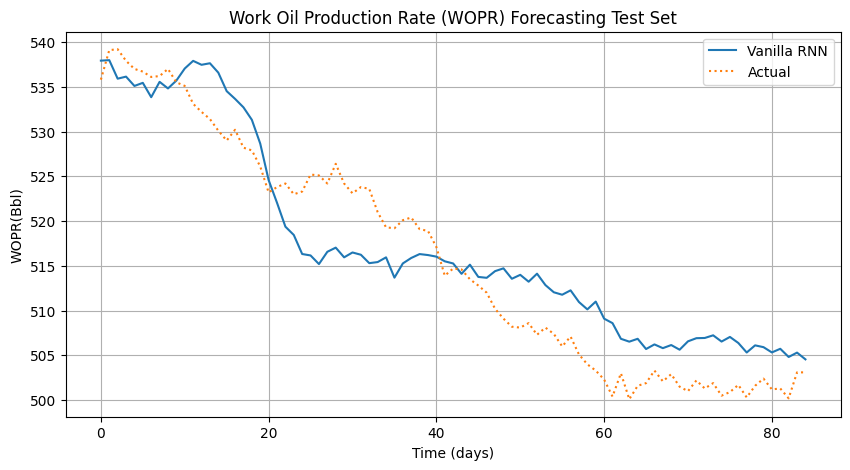

In [93]:
plt.figure(figsize=(10,5))
plt.plot(Y_pred_test_RNN, label='Vanilla RNN')
plt.plot(Y_test_act, label='Actual', ls= "dotted")
plt.title('Work Oil Production Rate (WOPR) Forecasting Test Set')
plt.xlabel('Time (days)')
plt.ylabel('WOPR(Bbl)')
plt.grid(True)
plt.legend()
plt.show()

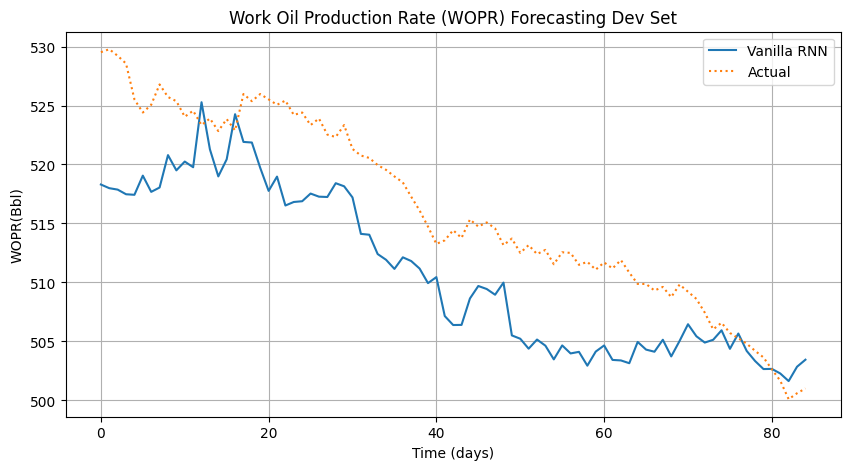

In [94]:
plt.figure(figsize=(10,5))
plt.plot(Y_pred_dev_RNN, label='Vanilla RNN')
plt.plot(Y_dev_act, label='Actual', ls= "dotted")
plt.title('Work Oil Production Rate (WOPR) Forecasting Dev Set')
plt.xlabel('Time (days)')
plt.ylabel('WOPR(Bbl)')
plt.grid(True)
plt.legend()
plt.show()

LSTM Model Loss: [0.015039798803627491, 0.10591187328100204, 0.0117647061124444]
GRU Model Loss: [0.022348690778017044, 0.13272692263126373, 0.0117647061124444]
Vanilla RNN Model Loss: [0.015265276655554771, 0.1100679263472557, 0.0117647061124444]
LSTM Model Loss_val: [0.013887633569538593, 0.10935142636299133, 0.0117647061124444]
GRU Model Loss_val: [0.025615930557250977, 0.14314717054367065, 0.0117647061124444]
Vanilla RNN Model Loss_val: [0.023784395307302475, 0.13790637254714966, 0.0117647061124444]


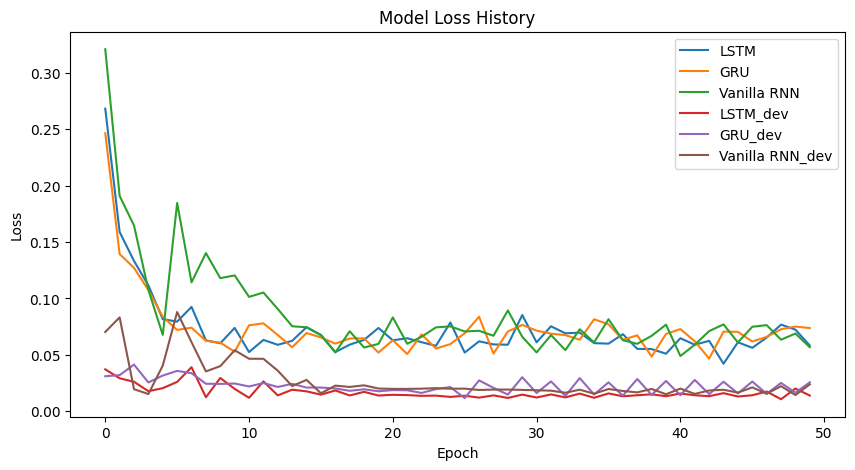

In [95]:
# Evaluate the models
loss_LSTM = model_LSTM.evaluate(X_test, Y_test, verbose=0)
loss_GRU = model_GRU.evaluate(X_test, Y_test, verbose=0)
loss_Vanilla = model_Vanilla.evaluate(X_test, Y_test, verbose=0)
loss_LSTM_val = model_LSTM.evaluate(X_dev, Y_dev, verbose=0)
loss_GRU_val = model_GRU.evaluate(X_dev, Y_dev, verbose=0)
loss_Vanilla_val = model_Vanilla.evaluate(X_dev, Y_dev, verbose=0)

print('LSTM Model Loss:', loss_LSTM)
print('GRU Model Loss:', loss_GRU)
print('Vanilla RNN Model Loss:', loss_Vanilla)
print('LSTM Model Loss_val:', loss_LSTM_val)
print('GRU Model Loss_val:', loss_GRU_val)
print('Vanilla RNN Model Loss_val:', loss_Vanilla_val)

# Plot the loss history of each model
plt.figure(figsize=(10,5))
plt.plot(history_LSTM.history['loss'], label='LSTM')
plt.plot(history_GRU.history['loss'], label='GRU')
plt.plot(history_Vanilla.history['loss'], label='Vanilla RNN')
plt.plot(history_LSTM.history['val_loss'], label='LSTM_dev')
plt.plot(history_GRU.history['val_loss'], label='GRU_dev')
plt.plot(history_Vanilla.history['val_loss'], label='Vanilla RNN_dev')
plt.title('Model Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

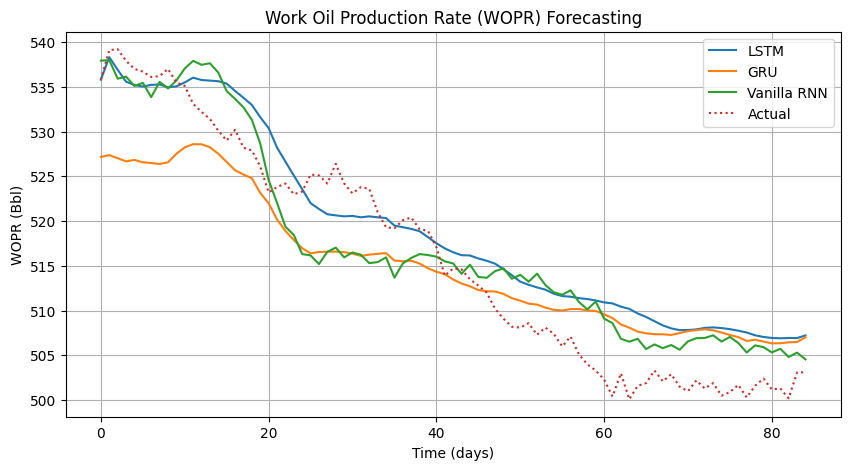

In [96]:

# Plot the predicted and actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(Y_pred_test_LSTM, label='LSTM')
plt.plot(Y_pred_test_GRU, label='GRU')
plt.plot(Y_pred_test_RNN, label='Vanilla RNN')
plt.plot(Y_test_act, label='Actual', ls= "dotted")
plt.title('Work Oil Production Rate (WOPR) Forecasting')
plt.xlabel('Time (days)')
plt.ylabel('WOPR (Bbl)')
plt.grid(True)
plt.legend()
plt.show()



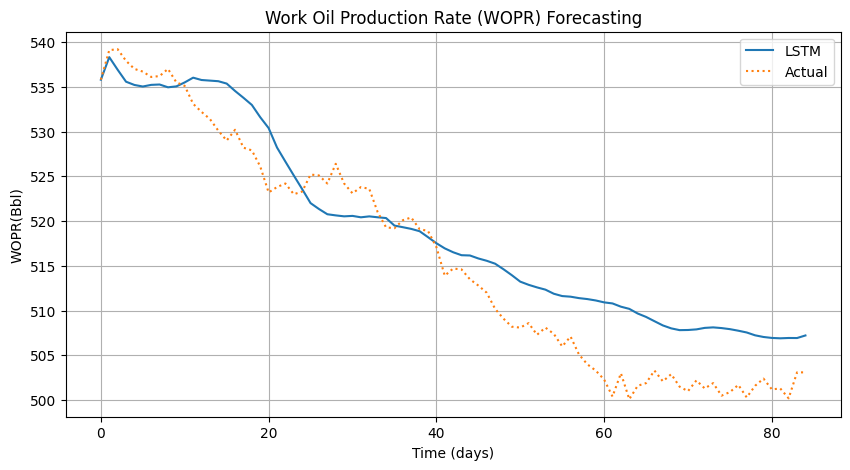

In [97]:
plt.figure(figsize=(10,5))
plt.plot(Y_pred_test_LSTM, label='LSTM')
plt.plot(Y_test_act, label='Actual', ls= "dotted")
plt.title('Work Oil Production Rate (WOPR) Forecasting')
plt.xlabel('Time (days)')
plt.ylabel('WOPR(Bbl)')
plt.grid(True)
plt.legend()
plt.show()


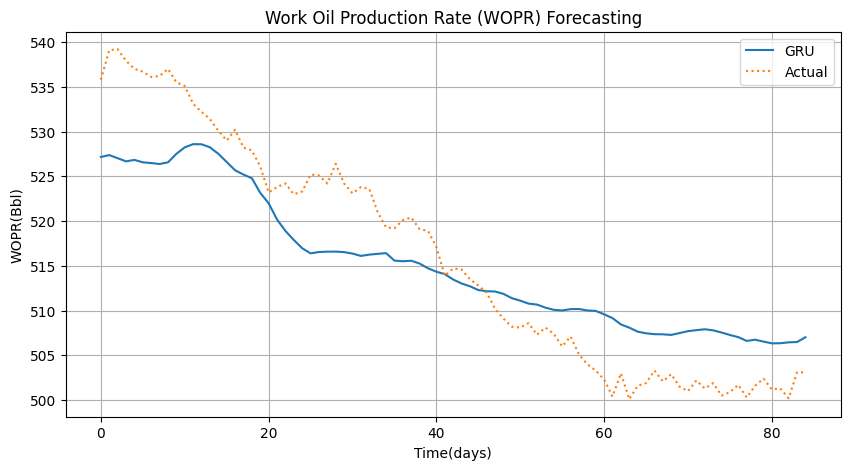

In [98]:
plt.figure(figsize=(10,5))

plt.plot(Y_pred_test_GRU, label='GRU')
plt.plot(Y_test_act, label='Actual', ls= "dotted")
plt.title('Work Oil Production Rate (WOPR) Forecasting')
plt.xlabel('Time(days)')
plt.ylabel('WOPR(Bbl)')
plt.grid(True)
plt.legend()
plt.show()


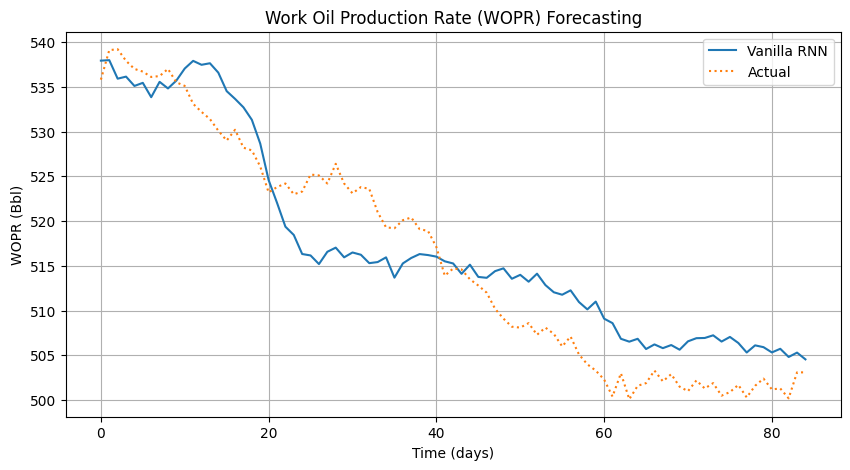

In [99]:
plt.figure(figsize=(10,5))

plt.plot(Y_pred_test_RNN, label='Vanilla RNN')
plt.plot(Y_test_act, label='Actual', ls= "dotted")
plt.title('Work Oil Production Rate (WOPR) Forecasting')
plt.xlabel('Time (days)')
plt.ylabel('WOPR (Bbl)')
plt.grid(True)
plt.legend()
plt.show()


In [100]:
'''
train_mse=mean_squared_error(Y_train, Y_pred_LSTM)
dev_mse=mean_squared_error(Y_dev, Y_pred_LSTM)
'''
test_mse=mean_squared_error(Y_test_act, Y_pred_test_LSTM)
'''
train_mse_GRU=mean_squared_error(Y_train, Y_pred_GRU)
dev_mse_GRU=mean_squared_error(Y_dev, Y_pred_GRU)
'''
test_mse_GRU=mean_squared_error(Y_test_act, Y_pred_test_GRU)
'''
train_mse_RNN=mean_squared_error(Y_train, Y_pred_Vanilla)
dev_mse_RNN=mean_squared_error(Y_dev, Y_pred_Vanilla)
'''
test_mse_RNN=mean_squared_error(Y_test_act, Y_pred_test_RNN)
'''
print('Training Set MSE: %1.4f' % train_mse)
print('Dev Set MSE: %1.4f' % dev_mse)
'''
print('Test Set MSE_LSTM: %1.4f' % test_mse)
'''
print('Training Set MSE: %1.4f' % train_mse_GRU)
print('Dev Set MSE: %1.4f' % dev_mse_GRU)
'''
print('Test Set MSE_GRU: %1.4f' % test_mse_GRU)
'''
print('Training Set MSE: %1.4f' % train_mse_RNN)
print('Dev Set MSE: %1.4f' % dev_mse_RNN)
'''
print('Test Set MSE_VanillaRNN: %1.4f' % test_mse_RNN)

Test Set MSE_LSTM: 23.9435
Test Set MSE_GRU: 35.5793
Test Set MSE_VanillaRNN: 24.3025


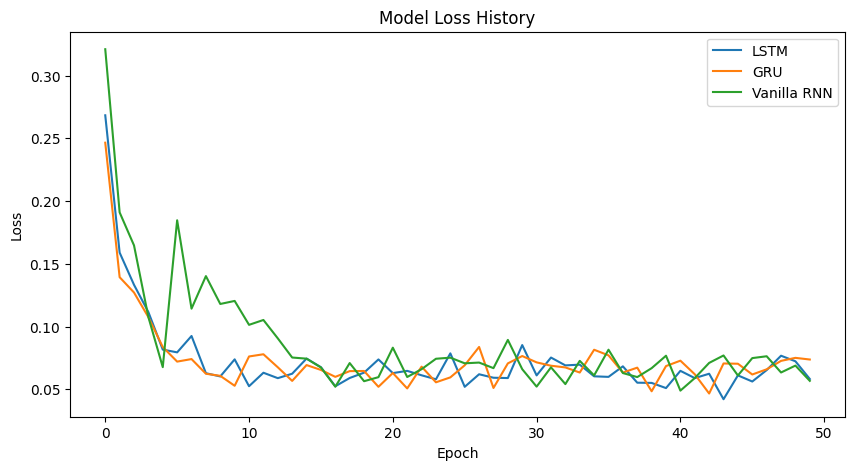

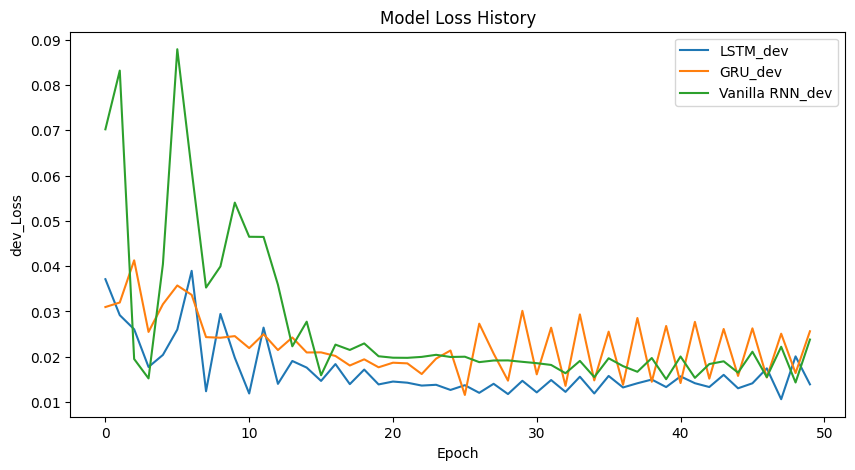

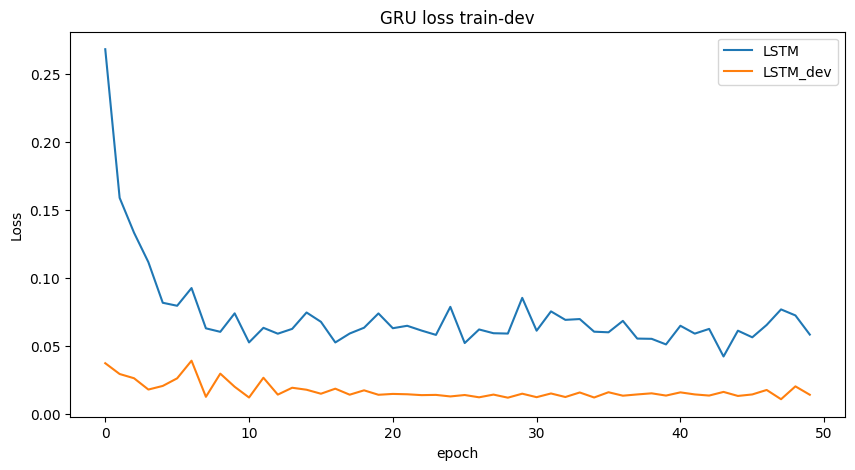

In [101]:
# Plot the loss history of each model
plt.figure(figsize=(10,5))
plt.plot(history_LSTM.history['loss'], label='LSTM')
plt.plot(history_GRU.history['loss'], label='GRU')
plt.plot(history_Vanilla.history['loss'], label='Vanilla RNN')
plt.title('Model Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history_LSTM.history['val_loss'], label='LSTM_dev')
plt.plot(history_GRU.history['val_loss'], label='GRU_dev')
plt.plot(history_Vanilla.history['val_loss'], label='Vanilla RNN_dev')
plt.title('Model Loss History')
plt.xlabel('Epoch')
plt.ylabel('dev_Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history_LSTM.history['loss'], label='LSTM')
plt.plot(history_LSTM.history['val_loss'], label ='LSTM_dev')
plt.title('GRU loss train-dev')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()